In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except ModuleNotFoundError:
    print('Not running on Google')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%matplotlib inline

In [ ]:
from __future__ import print_function, division
import os
import time
import copy
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils, models, datasets
import torch.nn as nn
import torch.optim as optim
import nibabel as nib
import scipy.ndimage as ndi
from pathlib import Path
from PIL import Image
import io
import json
import random

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.13.1+cu116
Torchvision Version:  0.14.1+cu116


# Configuración

In [ ]:
imagesFolder = '/content/gdrive/MyDrive/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed4'
fleniImagesFolder = '/content/gdrive/MyDrive/Tesis/Imagenes/fleni-stripped-preprocessed3'
trainDatasetCSV = '/content/gdrive/MyDrive/Tesis/Imagenes/ADNI-MUESTRA-930/MUESTRA_train.csv'
valDatasetCSV =   '/content/gdrive/MyDrive/Tesis/Imagenes/ADNI-MUESTRA-930/MUESTRA_val.csv'
fleniValDatasetCSV =   '/content/gdrive/MyDrive/Tesis/Imagenes/fleni-stripped-preprocessed/match-curated.csv'
experimentName = 'Muestra3700_2_test4'
experimentOutputFolder = 'muestra3700_2'
experimentDescription = 'Probamos nuevo código de select criteria con f1AD. NOTA: USA ADNI-MUESTRA-930. 50 epochs para ver cómo evoluciona.'
executions = 1

In [ ]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "inception"

# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 32

dl_num_workers = 4

# Number of epochs to train for
num_epochs = 50

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

usePretrained = True

# Habilita la salida auxiliar
auxEnabled = True

learningRate = 0.0001
dropoutRate = 0.6
crossEntrophyWeigths = torch.tensor([759.0,444.0,1717.0]) # Órden: CN, AD, MCI

#trainMean = 0.1716601789041244 #preproc3, 0s eliminados
#trainStd = 0.3936839672084841 #preproc3
trainMean = 0.1534203209139499  #preproc4, sin eliminar 0s
trainStd =  0.4048895150096513   #preproc4
normalization = {
  #"trainMeans": [0.485, 0.456, 0.406], # ImageNet
  #"trainStds": [0.229, 0.224, 0.225].  # ImageNet
  "trainMeans": [trainMean, trainMean, trainMean],
  "trainStds": [trainStd, trainStd, trainStd]
}

deviceName = 'cuda:0'

# Data augmentation
dataAugmentation = {
    "angleTransformChance": 1.0,
    "zoomTransformChance":  1.0,
    "shiftTransformChance": 1.0,
    "shearTransformChance": 1.0,
    "angle": 8
}
# dataAugmentation = {}

selectCriteria = "f1AD"

validationCacheSize = 0
trainCacheSize = 0

debug = False

In [ ]:
if not os.path.exists(experimentOutputFolder):
  print("Creando carpeta " + experimentOutputFolder)
  os.mkdir(experimentOutputFolder)

In [ ]:
f = open(os.path.join(experimentOutputFolder, experimentName + "_params.txt"), "w")
f.write("batch_size: " + str(batch_size) + "\n")
f.write("dl_num_workers: " + str(dl_num_workers) + "\n")
f.write("epochs: " + str(num_epochs) + "\n")
f.write("feature_extract: " + str(feature_extract) + "\n")
f.write("usePretrained: " + str(usePretrained) + "\n")
f.write("auxEnabled: " + str(auxEnabled) + "\n")
f.write("learningRate: " + str(learningRate) + "\n")
f.write("dropoutRate: " + str(dropoutRate) + "\n")
f.write("cross entrophy weights: " + str(crossEntrophyWeigths) + "\n")
f.write("dataAugmentation: " + str(json.dumps(dataAugmentation)) + "\n")
f.write("selectCriteria: " + str(selectCriteria) + "\n")
f.write("executions: " + str(executions) + "\n")
f.write("normalization: " + str(json.dumps(normalization)) + "\n")
f.write("deviceName: " + str(deviceName) + "\n")
f.write("validationCacheSize: " + str(validationCacheSize) + "\n")
f.write("trainCacheSize: " + str(trainCacheSize) + "\n")
f.close()

In [ ]:
f = open(os.path.join(experimentOutputFolder, experimentName + "_descripcion.txt"), "w")
f.write(experimentDescription)
f.close()

# Utilidades

In [ ]:
selectCriteriaAbbrv = {
    "accuracy": "acc",
    "f1AD": "f1AD",
}[selectCriteria]

In [ ]:
def logDebug(str):
    if debug:
        print(str)

In [ ]:
def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = ndi.zoom(img, zoom_tuple, **kwargs)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = ndi.zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

In [ ]:
class LoadImage(object):
    """Loads an image
    """

    def __init__(self, imagesFolder):
      self.imagesFolder = imagesFolder

    def __call__(self, studyID):
      imageFile = os.path.join(self.imagesFolder, studyID, "resampled-normalized.nii")
      metadataFile = os.path.join(self.imagesFolder, studyID, "metadata.json")
      f = open(metadataFile, "r")
      metadata = json.load(f)
      f.close()

      return nib.load(imageFile), metadata

In [ ]:
class TransformGridImage():
    def __init__(self, angle = None, zoom = None, shiftX = None, shiftY = None, shear = None, angleTransformChance = 0.1, zoomTransformChance = 0.1, shiftTransformChance = 0.1, shearTransformChance = 0.0):
      self.angle = angle
      self.zoom = zoom
      self.shiftX = shiftX
      self.shiftY = shiftY
      self.shear = shear
      self.angleTransformChance = angleTransformChance
      self.zoomTransformChance = zoomTransformChance
      self.shiftTransformChance = shiftTransformChance
      self.shearTransformChance = shearTransformChance
      self.sliceWidth = 128
      self.sliceHeight = 128

    def __call__(self, studyData):
      sample = studyData[0]
      metadata = studyData[1]

      brain_vol_data = sample.get_fdata()
      fig_rows = 4
      fig_cols = 4
      n_subplots = fig_rows * fig_cols

      deleteIndices = metadata["deleteIndices"]
    
      brain_vol_data = np.delete(brain_vol_data, deleteIndices, axis=2)
    
      n_slice = brain_vol_data.shape[2]

      step_size = n_slice / n_subplots

      slice_indices = np.arange(0, n_slice, step = step_size)

      channels = 3
      grid = np.empty( shape = (fig_rows * 128, fig_cols * 128, channels), dtype=np.float32)
      
      angle = self.angle
      zoom = self.zoom
      shiftX = self.shiftX
      shiftY = self.shiftY
      shear = self.shear

      if self.angle == None or self.angleTransformChance < random.uniform(0.0, 1.0):
        angle = 0.0 # Disable random angle
      else:
        angle = random.uniform(-self.angle, self.angle) 
        print(angle)
        
      if self.zoom != None and random.uniform(0.0, 1.0) > self.zoomTransformChance:
        zoom = None
      elif self.zoom != None:
        zoom = 1.0 + random.uniform(-self.zoom, self.zoom) 
        
      if self.shiftX != None and random.uniform(0.0, 1.0) > self.shiftTransformChance:
        shiftX = None
      elif self.shiftX != None:
        shiftX = round(128 * random.uniform(-self.shiftX, self.shiftX) / 100.0)

      if self.shiftY != None and random.uniform(0.0, 1.0) > self.shiftTransformChance:
        shiftY = None
      elif self.shiftY != None:
        shiftY = round(128 * random.uniform(-self.shiftY, self.shiftY) / 100.0)
        
      if self.shear != None and random.uniform(0.0, 1.0) > self.shearTransformChance:
        shear = None
      else:
        shear = random.uniform(-self.shear, self.shear)
        
      slice_index = 0
      for i in range(0, fig_rows):
        for j in range(0, fig_cols):
            slice_index  = slice_indices[i * fig_rows + j]
            processedImage = ndi.rotate(brain_vol_data[:, :, round(slice_index)], 90.0 + angle, mode='nearest', reshape = False)

            if zoom != None:
                processedImage = clipped_zoom(processedImage, zoom, mode = 'nearest')

            if shiftX != None:
                processedImage = ndi.shift(processedImage, [0.0, shiftX], mode = 'nearest')

            if shiftY != None:
                processedImage = ndi.shift(processedImage, [shiftY, 0.0], mode = 'nearest')
                
            if shear != None:
                transform = [[1, 0, 0],
                [shear, 1, 0],
                [0, 0, 1]]
                processedImage = ndi.affine_transform(processedImage,
                    transform,
                    offset=(0, -self.sliceHeight//2, 0),
                    output_shape=(self.sliceWidth, self.sliceHeight))
                 

            rowStart = i * 128
            rowEnd = (i + 1) * 128
            colStart = j * 128
            colEnd = (j+1)*128
            
            # 3 channels
            for c in range(0, channels):
              grid[rowStart:rowEnd, colStart:colEnd, c] = processedImage.copy()

            slice_index += 1

      return grid

In [ ]:
class ToLabelOutput(object):
    def __call__(self, label):
        if label == "CN":
            return 0
        elif label == "AD":
            return 1
        else:
            return 2 # MCI, LMCI, EMCI

In [ ]:
class FleniMyriamDataset(Dataset):
    """Fleni Myriam dataset."""

    def __init__(self, name, csv_file, root_dir, transform=None, target_transform = None, 
                 cacheSize = 200):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.name = name
        self.csv = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        # item_cache directamente almacena los items procesados
        self.cacheSize = cacheSize
        self.item_cache = [None] * cacheSize
        self.cachedItems = 0

    def __len__(self):
      return int(len(self.csv))

    def storeInCache(self, idx, image, label, metadata):
        if self.cacheSize > 0 and self.item_cache[idx % self.cacheSize] == None:  
            logDebug(self.name + "] Storing item in cache: " + str(idx))
            self.cachedItems += 1
            # Storing item in cache
            self.item_cache[idx % self.cacheSize] = {
                "id": idx,
                "label": label,
                "image": image,
                "metadata": metadata
            }
            logDebug(self.name + "] Cached items: " + str(self.cachedItems))

    def itemInCache(self, idx):
        if self.cacheSize > 0 and self.item_cache[idx % self.cacheSize] != None and self.item_cache[idx % self.cacheSize]["id"] == idx:
            return self.item_cache[idx % self.cacheSize]
        else:
            return None

    def loadImage(self, studyID):
      imageFile = os.path.join(self.root_dir, studyID, "resampled-normalized.nii")
      metadataFile = os.path.join(self.root_dir, studyID, "metadata.json")
      f = open(metadataFile, "r")
      metadata = json.load(f)
      f.close()

      return nib.load(imageFile), metadata

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if self.itemInCache(idx):
            item = self.itemInCache(idx)
            image = item["image"]
            metadata = item["metadata"]
            label = item["label"]
        else:
          studyID = self.csv.iloc[idx]['pet_id']
          #subjectID = self.csv.iloc[idx, 1]
          #processFormat = self.csv.iloc[idx, 7]
          #date = self.csv.iloc[idx, 9]
          diag = self.csv.iloc[idx]['diag']

          if diag == 1:
            label = 'AD'
          else:
            label = 'MCI'

          image, metadata = self.loadImage(studyID)

        self.storeInCache(idx, image, label, metadata)
        
        if self.transform:
            image = self.transform([image, metadata])
            
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [ ]:
class ADNIDataset(Dataset):
    """ADNI dataset."""

    def __init__(self, name, csv_file, root_dir, transform=None, target_transform = None, 
                 cacheSize = 200, indexOffset = 0):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.name = name
        self.csv = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        # item_cache directamente almacena los items procesados
        self.cacheSize = cacheSize
        self.item_cache = [None] * cacheSize
        self.cachedItems = 0
        self.indexOffset = indexOffset

    def __len__(self):
      return int(len(self.csv))

    def storeInCache(self, idx, image, label, metadata):
        if self.cacheSize > 0 and self.item_cache[idx % self.cacheSize] == None:  
            logDebug(self.name + "] Storing item in cache: " + str(idx))
            self.cachedItems += 1
            # Storing item in cache
            self.item_cache[idx % self.cacheSize] = {
                "id": idx,
                "label": label,
                "image": image,
                "metadata": metadata
            }
            logDebug(self.name + "] Cached items: " + str(self.cachedItems))

    def itemInCache(self, idx):
        if self.cacheSize > 0 and self.item_cache[idx % self.cacheSize] != None and self.item_cache[idx % self.cacheSize]["id"] == idx:
            return self.item_cache[idx % self.cacheSize]
        else:
            return None

    def loadImage(self, studyID):
      imageFile = os.path.join(self.root_dir, studyID, "resampled-normalized.nii")
      metadataFile = os.path.join(self.root_dir, studyID, "metadata.json")
      f = open(metadataFile, "r")
      metadata = json.load(f)
      f.close()

      return nib.load(imageFile), metadata

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if self.itemInCache(idx):
            item = self.itemInCache(idx)
            image = item["image"]
            metadata = item["metadata"]
            label = item["label"]
        else:
          # +1 por el índice que guarda Pandas
          studyID = self.csv.iloc[idx, 0 + self.indexOffset]
          label = self.csv.iloc[idx, 2 + self.indexOffset]

          image, metadata = self.loadImage(studyID)
          self.storeInCache(idx, image, label, metadata)
        

        if self.transform:
            image = self.transform([image, metadata])
            
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [ ]:
def printFile(text, file):
  print(text)
  if file != None:
      file.write(text + "\n")

# Modelo

In [ ]:
def select_criteria_accuracy_aggregate(running_corrects, preds, labels):
  return running_corrects + torch.sum(preds == labels.data)

def select_criteria_accuracy_epoch_result(running_corrects, dataset):
  return running_corrects.double() / len(dataset)

In [ ]:
def select_criteria_f1AD_aggregate(aggregate, preds, labels):
  if aggregate == None: # init
    aggregate = {
        "preds": torch.clone(preds),
        "labels": torch.clone(labels.data),
    }
    return aggregate 
  else:
    aggregate["preds"] = torch.cat((aggregate["preds"], torch.clone(preds)))
    aggregate["labels"] = torch.cat((aggregate["labels"], torch.clone(labels.data)))
    return aggregate 

def select_criteria_f1AD_epoch_result(aggregate, dataset):
  fn = 0
  fp = 0
  tp = 0
  preds = aggregate["preds"]
  labels = aggregate["labels"]
  AD = ToLabelOutput()("AD")
  for i in range(0, len(preds)):
    if preds[i] != AD and labels[i] != AD: # solo nos interesa AD
      continue
    if preds[i] == AD and labels[i] == AD:
      tp += 1
    if preds[i] == AD and labels[i] != AD:
      fp += 1
    if preds[i] != AD and labels[i] == AD:
      fn += 1

  # avoid division by zero
  # https://stats.stackexchange.com/questions/8025/what-are-correct-values-for-precision-and-recall-when-the-denominators-equal-0
  if tp == 0 and (fp != 0 or fn != 0):
    print("\1")
    return 0
  elif tp == 0:
    print("\2")
    return 1

  recall = 1.0 * tp / (tp + fn)
  precision = 1.0 * tp / (tp + fp)
  return 2.0 * precision * recall / (precision + recall)

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=True, logFile = None, selection_criteria = "accuracy"):
    f = None
    if logFile != None:
        f = open(logFile, "w")

    since = time.time()

    train_acc_history = []
    val_acc_history = []
    train_selection_criteria_history = []
    val_selection_criteria_history = []
    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_selection_criteria = 0.0

    # This allows to select different select criteria for selecting the "best epoch" one
    if selection_criteria == "accuracy":
      select_criteria_aggregate = select_criteria_accuracy_aggregate
      select_criteria_epoch_result = select_criteria_accuracy_epoch_result
    elif selection_criteria == "f1AD":
      select_criteria_aggregate = select_criteria_f1AD_aggregate
      select_criteria_epoch_result = select_criteria_f1AD_epoch_result      
    else:
      raise Exception("Invalid selection criteria")

    for epoch in range(num_epochs):
        printFile('Epoch {}/{}'.format(epoch, num_epochs - 1), f)
        printFile('-' * 10, f)

        # Each epoch has a training and validation phase
        # , 'valFleni'
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            selection_criteria_aggregate = None
            it = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        if auxEnabled: 
                          loss1 = criterion(outputs, labels)
                          loss2 = criterion(aux_outputs, labels)
                          loss = loss1 + 0.4*loss2                     
                        else:
                          loss = criterion(outputs, labels)
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += + torch.sum(preds == labels.data)
                # if phase == 'val':
                selection_criteria_aggregate = select_criteria_aggregate(selection_criteria_aggregate, preds, labels.data)

                logDebug("Iteration " + str(it))
                it += 1

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            # if phase == 'val':
            epoch_selection_criteria = select_criteria_epoch_result(selection_criteria_aggregate, dataloaders[phase].dataset)

            printFile('{} Loss: {:.4f} Acc: {:.4f} {}: {:.4f}'.format(phase, epoch_loss, epoch_acc, selection_criteria, epoch_selection_criteria), f)

            # deep copy the model
            if phase == 'val' and epoch_selection_criteria > best_selection_criteria:
                best_selection_criteria = epoch_selection_criteria
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
                val_selection_criteria_history.append(epoch_selection_criteria)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
                train_selection_criteria_history.append(epoch_selection_criteria)
            

    time_elapsed = time.time() - since
    printFile('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60), f)
    printFile('Best val {}: {:4f}'.format(selection_criteria, best_selection_criteria), f)

    # load best model weights
    model.load_state_dict(best_model_wts)
    if logFile != None:
        f.close()
    return model, val_acc_history, val_loss_history, train_acc_history, train_loss_history, val_selection_criteria_history, train_selection_criteria_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Initialize and reshape inception

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained, 
                                       aux_logits = True)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        # num_ftrs = model_ft.AuxLogits.fc.in_features
        # model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        print("num featurs" + str(num_ftrs))
        # Fuente: https://github.com/bdrad/petdementiapub/blob/master/petdementia_source.py
        model_ft.dropout = nn.Dropout(dropoutRate)
        model_ft.fc = nn.Sequential(
          nn.Linear(num_ftrs,1024),
          nn.ReLU(),
          nn.Linear(1024,num_classes),
        )

        if auxEnabled :
          model_ft.AuxLogits.fc = nn.Sequential(
            nn.Linear(768,num_classes), # elegido arbitrariamentoe
          )
          
        input_size = 512 

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=usePretrained)

# Print the model we just instantiated
print(model_ft)

num featurs2048
Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_s

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation

valGridArgs = {}

data_transforms = {
    'train': transforms.Compose([
        #LoadImage(imagesFolder),
        TransformGridImage(**dataAugmentation),
        transforms.ToTensor(),
        transforms.Normalize(normalization["trainMeans"], normalization["trainStds"])
    ]),
    'val': transforms.Compose([
        #LoadImage(imagesFolder),
        TransformGridImage(),
        transforms.ToTensor(),
        transforms.Normalize(normalization["trainMeans"], normalization["trainStds"])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets

image_datasets = {
    'train': ADNIDataset('trainDL', trainDatasetCSV, imagesFolder, transform = data_transforms['train'], target_transform =ToLabelOutput(), cacheSize = trainCacheSize),
    'val': ADNIDataset('valDL', valDatasetCSV, imagesFolder, transform = data_transforms['val'], target_transform =ToLabelOutput(), cacheSize = validationCacheSize ),
    # 'valFleni': FleniMyriamDataset('valFleniDL', fleniValDatasetCSV, fleniImagesFolder, transform = data_transforms['val'], target_transform =ToLabelOutput(), cacheSize = validationCacheSize ),
}

# Create training and validation dataloaders
# , 'valFleni'
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=dl_num_workers) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device(deviceName if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=learningRate)


Params to learn:
	 Conv2d_1a_3x3.conv.weight
	 Conv2d_1a_3x3.bn.weight
	 Conv2d_1a_3x3.bn.bias
	 Conv2d_2a_3x3.conv.weight
	 Conv2d_2a_3x3.bn.weight
	 Conv2d_2a_3x3.bn.bias
	 Conv2d_2b_3x3.conv.weight
	 Conv2d_2b_3x3.bn.weight
	 Conv2d_2b_3x3.bn.bias
	 Conv2d_3b_1x1.conv.weight
	 Conv2d_3b_1x1.bn.weight
	 Conv2d_3b_1x1.bn.bias
	 Conv2d_4a_3x3.conv.weight
	 Conv2d_4a_3x3.bn.weight
	 Conv2d_4a_3x3.bn.bias
	 Mixed_5b.branch1x1.conv.weight
	 Mixed_5b.branch1x1.bn.weight
	 Mixed_5b.branch1x1.bn.bias
	 Mixed_5b.branch5x5_1.conv.weight
	 Mixed_5b.branch5x5_1.bn.weight
	 Mixed_5b.branch5x5_1.bn.bias
	 Mixed_5b.branch5x5_2.conv.weight
	 Mixed_5b.branch5x5_2.bn.weight
	 Mixed_5b.branch5x5_2.bn.bias
	 Mixed_5b.branch3x3dbl_1.conv.weight
	 Mixed_5b.branch3x3dbl_1.bn.weight
	 Mixed_5b.branch3x3dbl_1.bn.bias
	 Mixed_5b.branch3x3dbl_2.conv.weight
	 Mixed_5b.branch3x3dbl_2.bn.weight
	 Mixed_5b.branch3x3dbl_2.bn.bias
	 Mixed_5b.branch3x3dbl_3.conv.weight
	 Mixed_5b.branch3x3dbl_3.bn.weight
	 Mixed_5b.b

In [ ]:
def test_model(model,dataloaders,device, phaseKey = 'val'):
    classStats = [{
        'fn': 0,
        'tn': 0,
        'tp': 0,
        'fp': 0,
        'n': 0,
    } for i in range(num_classes)]
    correctlyPredicted = 0
    n = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloaders[phaseKey]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Iteramos para chequear estadisticas
            for i, correctClass in enumerate(labels.data):
              n += 1
              predictedClass = int(preds[i].item())
              correctClass = int(correctClass.item())
              classStats[correctClass]['n'] += 1
              if correctClass == predictedClass:
                  correctlyPredicted += 1
                  classStats[correctClass]['tp'] += 1
                  for i in range(num_classes):
                      if i != correctClass:
                          classStats[correctClass]['tn'] += 1
              else:
                  classStats[correctClass]['fn'] += 1
                  classStats[predictedClass]['fp'] += 1
                  for i in range(num_classes):
                      if i != correctClass and i != predictedClass:
                          classStats[correctClass]['tn'] += 1
    accuracy = correctlyPredicted * 1.0 / n
    return classStats, accuracy

In [ ]:
def printClassStats(stats):
  recall = sensitivity = stats['tp'] / (stats['tp'] + stats['fn']) # prob positive test result
  specificity = stats['tn'] / (stats['tn'] + stats['fp'])          # prob negative test result
  if stats['tp'] + stats['fp'] > 0:
    precision = stats['tp'] / (stats['tp'] + stats['fp'])          # prob of recognized positive actually correct
  else:
    precision = 1
    printFile("Setting precision as 1 but no positive value has been reported, so this is placeholder", f)
  if precision + recall == 0:
    printFile("Setting f1 as 0 because precision + recall is ZERO", f)
    f1 = 0.0
  else:
    f1 = 2 * (precision * recall) / ( precision + recall )
  printFile("Sensitivity (%): " + str(round(sensitivity * 100)), f)
  printFile("Specificity (%): " + str(round(specificity * 100)), f)
  printFile("Precision  (%): " + str(round(precision * 100)), f)
  printFile("F1 Score  (%): " + str(round(f1 * 100)), f)
  printFile("Number of images: " + str(stats['n']), f)
  return recall, specificity, precision, f1

In [ ]:
accuracyValues = []
adStatValues = []
cnStatValues = []
mciStatValues = []
for i in range(0, executions):
    experimentExecutionName = experimentName + '_' + str(i)
    print("--- Execution " + str(i) + " begin ---")
    # Setup the loss fxn
    crossEntrophyWeigths = crossEntrophyWeigths.to(device)
    criterion = nn.CrossEntropyLoss(crossEntrophyWeigths)

    logFile = os.path.join(experimentOutputFolder, experimentExecutionName + '_train.log')

    # Train and evaluate
    model_ft, val_acc_hist, val_loss_hist, train_acc_hist, train_loss_hist, val_selection_criteria_hist, train_selection_criteria_hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"), logFile = logFile, selection_criteria = selectCriteria)

    torch.save(model_ft.state_dict(), os.path.join(experimentOutputFolder, experimentExecutionName + '.pth'))

    # validation accuracy
    fig = plt.figure()
    lst = [ x.cpu().item() for x in val_acc_hist ]
    plt.plot(lst)
    ax = plt.gca()
    plt.text(0.05, 0.9, 'FE = ' + str(feature_extract), transform=ax.transAxes)
    plt.text(0.05, 0.8, 'LR = ' + str(learningRate), transform=ax.transAxes)
    plt.text(0.05, 0.7, 'batch = ' + str(batch_size), transform=ax.transAxes)
    plt.suptitle(experimentExecutionName + ' (acc set de validacion)')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.savefig(os.path.join(experimentOutputFolder, experimentExecutionName + '_val_acc.png'))
    plt.clf()

    # validation loss
    fig = plt.figure()
    plt.plot(val_loss_hist)
    ax = plt.gca()
    plt.text(0.05, 0.3, 'FE = ' + str(feature_extract), transform=ax.transAxes)
    plt.text(0.05, 0.2, 'LR = ' + str(learningRate), transform=ax.transAxes)
    plt.text(0.05, 0.1, 'batch = ' + str(batch_size), transform=ax.transAxes)
    plt.suptitle(experimentExecutionName + ' (loss set de validacion)')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.savefig(os.path.join(experimentOutputFolder, experimentExecutionName + '_val_loss.png'))
    plt.clf()

    # train accuracy
    fig = plt.figure()
    lst = [ x.cpu().item() for x in train_acc_hist ]
    ax = plt.gca()
    plt.text(0.05, 0.9, 'FE = ' + str(feature_extract), transform=ax.transAxes)
    plt.text(0.05, 0.8, 'LR = ' + str(learningRate), transform=ax.transAxes)
    plt.text(0.05, 0.7, 'batch = ' + str(batch_size), transform=ax.transAxes)
    plt.plot(lst)
    plt.suptitle(experimentExecutionName + ' (acc set de train)')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.savefig(os.path.join(experimentOutputFolder, experimentExecutionName + '_train_acc.png'))
    plt.clf()

    # train loss
    fig = plt.figure()
    ax = plt.gca()
    plt.text(0.05, 0.3, 'FE = ' + str(feature_extract), transform=ax.transAxes)
    plt.text(0.05, 0.2, 'LR = ' + str(learningRate), transform=ax.transAxes)
    plt.text(0.05, 0.1, 'batch = ' + str(batch_size), transform=ax.transAxes)
    plt.plot(train_loss_hist)
    plt.suptitle(experimentExecutionName + ' (Loss set de train)')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.savefig(os.path.join(experimentOutputFolder, experimentExecutionName + '_train_loss.png'))
    plt.clf()

    # validation selection criteria
    abbrv = selectCriteriaAbbrv
    fig = plt.figure()
    lst = [ x for x in val_selection_criteria_hist ]
    plt.plot(lst)
    ax = plt.gca()
    plt.text(0.05, 0.9, 'FE = ' + str(feature_extract), transform=ax.transAxes)
    plt.text(0.05, 0.8, 'LR = ' + str(learningRate), transform=ax.transAxes)
    plt.text(0.05, 0.7, 'batch = ' + str(batch_size), transform=ax.transAxes)
    plt.suptitle(experimentExecutionName + ' ('+abbrv+' set de validacion)')
    plt.ylabel(selectCriteria)
    plt.xlabel('Epochs')
    plt.savefig(os.path.join(experimentOutputFolder, experimentExecutionName + '_val_'+abbrv+'.png'))
    plt.clf()

    # train selection criteria
    fig = plt.figure()
    lst = [ x for x in train_selection_criteria_hist ]
    ax = plt.gca()
    plt.text(0.05, 0.9, 'FE = ' + str(feature_extract), transform=ax.transAxes)
    plt.text(0.05, 0.8, 'LR = ' + str(learningRate), transform=ax.transAxes)
    plt.text(0.05, 0.7, 'batch = ' + str(batch_size), transform=ax.transAxes)
    plt.plot(lst)
    plt.suptitle(experimentExecutionName + ' ('+abbrv+' set de train)')
    plt.ylabel(selectCriteria)
    plt.xlabel('Epochs')
    plt.savefig(os.path.join(experimentOutputFolder, experimentExecutionName + '_train_'+abbrv+'.png'))
    plt.clf()

    stats, accuracy = test_model(model_ft, dataloaders_dict, device)

    print("accuracy: " + str(accuracy))
    accuracyValues.append(accuracy)

    f = open(os.path.join(experimentOutputFolder, experimentExecutionName + "_stats.txt"), "w")
    printFile("CN stats: ", f)
    recall, specificity, precision, f1 = printClassStats(stats[0])
    cnStatValues.append({
        "recall": recall,
        "specificity": specificity,
        "precision": precision,
        "f1": f1
    })
    # AD
    printFile("\nAD stats: ", f)
    recall, specificity, precision, f1 = printClassStats(stats[1])
    adStatValues.append({
        "recall": recall,
        "specificity": specificity,
        "precision": precision,
        "f1": f1
    })
    # MCI
    printFile("\nMCI stats: ", f)
    recall, specificity, precision, f1 = printClassStats(stats[2])
    mciStatValues.append({
        "recall": recall,
        "specificity": specificity,
        "precision": precision,
        "f1": f1
    })
    f.close()

    print("--- Execution End ---")    

--- Execution 0 begin ---
Epoch 0/49
----------

train Loss: 1.3186 Acc: 0.3286 f1AD: 0.0000

val Loss: 0.9330 Acc: 0.3333 f1AD: 0.0000
Epoch 1/49
----------
train Loss: 0.9034 Acc: 0.4381 f1AD: 0.1250

val Loss: 0.9692 Acc: 0.3500 f1AD: 0.0000
Epoch 2/49
----------
train Loss: 0.4984 Acc: 0.8206 f1AD: 0.7464
val Loss: 1.2928 Acc: 0.3967 f1AD: 0.2087
Epoch 3/49
----------
train Loss: 0.2540 Acc: 0.9190 f1AD: 0.9086
val Loss: 1.9420 Acc: 0.4233 f1AD: 0.5233
Epoch 4/49
----------
train Loss: 0.2688 Acc: 0.9254 f1AD: 0.9208
val Loss: 1.7492 Acc: 0.4333 f1AD: 0.4690
Epoch 5/49
----------
train Loss: 0.1435 Acc: 0.9762 f1AD: 0.9832
val Loss: 1.9365 Acc: 0.4633 f1AD: 0.5391
Epoch 6/49
----------
train Loss: 0.1759 Acc: 0.9444 f1AD: 0.9317
val Loss: 1.3572 Acc: 0.5133 f1AD: 0.4730
Epoch 7/49
----------
train Loss: 0.0798 Acc: 0.9778 f1AD: 0.9734
val Loss: 2.3859 Acc: 0.4867 f1AD: 0.6167
Epoch 8/49
----------
train Loss: 0.1974 Acc: 0.9492 f1AD: 0.9639
val Loss: 2.2334 Acc: 0.4867 f1AD: 0.5

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
accuracyValues = torch.tensor(accuracyValues)
std, mean = torch.std_mean(accuracyValues)
f = open(os.path.join(
    os.path.join(experimentOutputFolder, experimentName + '_results.txt')), "w")
printFile("Final stats: ", f)
printFile("Executions: " + str(executions), f)
printFile("Accuracy mean: " + str(mean.item()), f)
printFile("Accuracy std: " + str(std.item()), f)
printFile("Best accuracy: " + str(accuracyValues.max().item()), f)
printFile("Worst accuracy: " + str(accuracyValues.min().item()), f)
f.close()

Final stats: 
Executions: 1
Accuracy mean: 0.5833333134651184
Accuracy std: nan
Best accuracy: 0.5833333134651184
Worst accuracy: 0.5833333134651184


# ROC - AUC

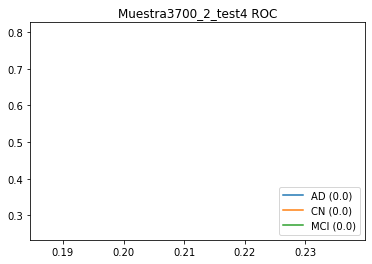

In [ ]:
def sortByX(point):
  return point[0]

# Se necesita ordenar los puntos para llamar a torch.trapezoid con los puntos ordenados por la coordenada X
def sortListsByX(x, y):
    points = zip(x, y)
    points = list(points)
    points.sort(key=sortByX)
    x, y = ([ a for a,b in points ], [ b for a,b in points ])
    return x, y

fig = plt.figure()
ad_y = ad_tpr = [ x["recall"] for x in adStatValues ]
ad_x = ad_fpr = [ 1.0 - x["specificity"] for x in adStatValues ]
ad_x, ad_y = sortListsByX(ad_x, ad_y)

cn_y = cn_tpr = [ x["recall"] for x in cnStatValues ]
cn_x = cn_fpr = [ 1.0 - x["specificity"] for x in cnStatValues ]
cn_x, cn_y = sortListsByX(cn_x, cn_y)

mci_y = mci_tpr = [ x["recall"] for x in mciStatValues ]
mci_x = mci_fpr = [ 1.0 - x["specificity"] for x in mciStatValues ]
mci_x, mci_y = sortListsByX(mci_x, mci_y)

decimals = 3
ad_auc = round(torch.trapezoid(torch.tensor(ad_y), torch.tensor(ad_x)).item(), decimals)
cn_auc = round(torch.trapezoid(torch.tensor(cn_y), torch.tensor(cn_x)).item(), decimals)
mci_auc = round(torch.trapezoid(torch.tensor(mci_y), torch.tensor(mci_x)).item(), decimals)

plt.title(experimentName + " ROC")

plt.plot(ad_fpr, ad_tpr)
plt.plot(cn_fpr, cn_tpr)
plt.plot(mci_fpr, mci_tpr)

plt.legend(["AD ("+str(ad_auc)+")", "CN ("+str(cn_auc)+")", "MCI ("+str(mci_auc)+")"], loc ="lower right")
plt.savefig(os.path.join(experimentOutputFolder, experimentExecutionName + '_auc_roc.png'))
    
plt.show()

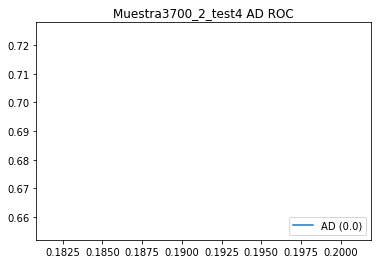

In [ ]:
fig = plt.figure()
ad_y = ad_tpr = [ x["recall"] for x in adStatValues ]
ad_x = ad_fpr = [ 1.0 - x["specificity"] for x in adStatValues ]
ad_x, ad_y = sortListsByX(ad_x, ad_y)

decimals = 3
ad_auc = round(torch.trapezoid(torch.tensor(ad_y), torch.tensor(ad_x)).item(), decimals)

plt.title(experimentName + " AD ROC")

plt.plot(ad_fpr, ad_tpr)

plt.legend(["AD ("+str(ad_auc)+")"], loc ="lower right")
plt.savefig(os.path.join(experimentOutputFolder, experimentExecutionName + '_auc_roc_ad.png'))

plt.show()

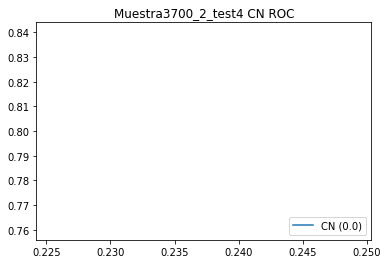

In [ ]:
fig = plt.figure()

cn_y = cn_tpr = [ x["recall"] for x in cnStatValues ]
cn_x = cn_fpr = [ 1.0 - x["specificity"] for x in cnStatValues ]
cn_x, cn_y = sortListsByX(cn_x, cn_y)

decimals = 3
cn_auc = round(torch.trapezoid(torch.tensor(cn_y), torch.tensor(cn_x)).item(), decimals)

plt.title(experimentName + " CN ROC")

plt.plot(cn_fpr, cn_tpr)

plt.legend(["CN ("+str(cn_auc)+")"], loc ="lower right")
plt.savefig(os.path.join(experimentOutputFolder, experimentExecutionName + '_auc_roc_cn.png'))

plt.show()

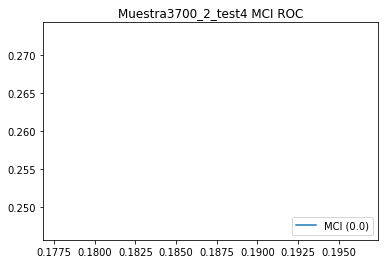

In [ ]:
fig = plt.figure()

mci_y = mci_tpr = [ x["recall"] for x in mciStatValues ]
mci_x = mci_fpr = [ 1.0 - x["specificity"] for x in mciStatValues ]
mci_x, mci_y = sortListsByX(mci_x, mci_y)

decimals = 3
mci_auc = round(torch.trapezoid(torch.tensor(mci_y), torch.tensor(mci_x)).item(), decimals)

plt.title(experimentName + " MCI ROC")

plt.plot(mci_fpr, mci_tpr)

plt.legend(["MCI ("+str(mci_auc)+")"], loc ="lower right")
plt.savefig(os.path.join(experimentOutputFolder, experimentExecutionName + '_auc_roc_mci.png'))

plt.show()

# Fleni Metrics

In [ ]:
trainGridArgs = {
    
}
valGridArgs = {}

data_transforms = {
    'train': transforms.Compose([
        TransformGridImage(**dataAugmentation),
        transforms.ToTensor(),
        transforms.Normalize(normalization["trainMeans"], normalization["trainStds"])
    ]),
    'val': transforms.Compose([
        TransformGridImage(),
        transforms.ToTensor(),
        transforms.Normalize(normalization["trainMeans"], normalization["trainStds"])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets

image_datasets = {
    #'train': ADNIDataset('trainDL', trainDatasetCSV, imagesFolder, transform = data_transforms['train'], target_transform =ToLabelOutput(), cacheSize = trainCacheSize),
    #'val': ADNIDataset('valDL', valDatasetCSV, imagesFolder, transform = data_transforms['val'], target_transform =ToLabelOutput(), cacheSize = validationCacheSize ),
    'valFleni': FleniMyriamDataset('valFleniDL', fleniValDatasetCSV, fleniImagesFolder, transform = data_transforms['val'], target_transform =ToLabelOutput(), cacheSize = validationCacheSize ),
}

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=dl_num_workers) for x in ['valFleni']}

# Detect if we have a GPU available
device = torch.device(deviceName if torch.cuda.is_available() else "cpu")

device = torch.device(deviceName if torch.cuda.is_available() else "cpu")
#model_state_dict = torch.load(os.path.join(experimentOutputFolder, experimentName + '_0.pth'), map_location=device)
#model_ft.load_state_dict(model_state_dict)
stats, accuracy = test_model(model_ft, dataloaders_dict, device, 'valFleni')

print("accuracy fleni: " + str(accuracy))

f = open(os.path.join(experimentOutputFolder, "fleni_stats.txt"), "w")
# f = None
# AD
printFile("\nAD stats: ", f)
recall, specificity, precision, f1 = printClassStats(stats[1])
#adStatValues.append({
#        "recall": recall,
#        "specificity": specificity,
#        "precision": precision,
#        "f1": f1
#})
# MCI
printFile("\nMCI stats: ", f)
recall, specificity, precision, f1 = printClassStats(stats[2])
#mciStatValues.append({
#        "recall": recall,
#        "specificity": specificity,
#        "precision": precision,
#        "f1": f1
#    })
f.close()

Initializing Datasets and Dataloaders...
accuracy fleni: 0.0

AD stats: 
Setting precision as 1 but no positive value has been reported, so this is placeholder
Sensitivity (%): 0
Specificity (%): 100
Precision  (%): 100
F1 Score  (%): 0
Number of images: 68

MCI stats: 
Setting precision as 1 but no positive value has been reported, so this is placeholder
Sensitivity (%): 0
Specificity (%): 100
Precision  (%): 100
F1 Score  (%): 0
Number of images: 44
